# Massachusetts pediatric influenza hospitalizations: counterfactual analysis (ages 0-17)

This notebook provides an estimate of excess influenza hospitalizations among Massachusetts children ages 0-17 under lower vaccination coverage. The analysis starts from observed hospitalizations and applies a simple counterfactual model to estimate how many additional hospitalizations would be expected at lower vaccine coverage.


## Data sources
Hospitalizations are drawn from NHSN HRD. Baseline coverage is drawn from CDC FluVaxView for Massachusetts children
ages 6 months-17 years. The coverage value is used as a high-uptake reference point, and the analysis then evaluates
a grid of lower coverage values.

- NHSN HRD weekly jurisdiction metrics (Socrata dataset `ua7e-t2fy`)
- CDC FluVaxView coverage (Socrata dataset `vh55-3he6`)


## Model (transparent counterfactual)
A leaky vaccine reduces the risk of hospitalization by a fixed fraction (the vaccine effectiveness, VE) among
vaccinated children. This model does not include herd effects or waning within the season.

Definitions:
- `B_obs`: observed hospitalizations in the season
- `c0`: baseline coverage (fraction vaccinated)
- `VE`: vaccine effectiveness (fractional reduction in risk for vaccinated children)
- `c1`: counterfactual coverage (fraction vaccinated under a lower-uptake scenario)

Equations:

$$B_0 = \frac{B_{obs}}{1 - c_0 \cdot VE}$$
$$B_1 = B_0 \cdot (1 - c_1 \cdot VE)$$
$$\Delta B = B_1 - B_{obs}$$

Where $B_0$ is the implied burden with no vaccination and $\Delta B$ is the excess burden under reduced coverage.


In [1]:
from pathlib import Path
import json
import math

import pandas as pd
import requests

output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)


## Parameters
The 2024-25 season is used because the NHSN pediatric influenza admissions field is populated for Massachusetts
starting in that season.

Massachusetts has high influenza vaccination coverage in the most recent published FluVaxView season (about 0.75).
The analysis fixes the baseline at 0.75 and evaluates a grid down to 0.00 in 0.05 steps.

Vaccine effectiveness varies by season and strain. A sensitivity grid from 0.35 to 0.60 in 0.05 steps is used to
show how results scale with effectiveness.

- Season window: 2024-10-01 to 2025-04-30 (2024-25 season)
- Jurisdiction: Massachusetts (`MA` in NHSN)
- Pediatric admissions field: `totalconfflunewadmped`
- Baseline coverage: 0.75 (fixed for sensitivity)
- Coverage grid: 0.75 down to 0.00 in 0.05 steps
- VE grid: 0.35 to 0.60 in 0.05 steps


In [2]:
season_id = '2024-25'
season_start = '2024-10-01'
season_end = '2025-04-30'

hrd_domain = 'data.cdc.gov'
hrd_dataset = 'ua7e-t2fy'
hrd_week_col = 'weekendingdate'
hrd_jurisdiction_col = 'jurisdiction'
hrd_jurisdiction_value = 'MA'
hrd_hosp_col = 'totalconfflunewadmped'

coverage_domain = 'data.cdc.gov'
coverage_dataset = 'vh55-3he6'
coverage_season_override = '2023-24'
coverage_baseline = 0.75

ve_grid = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
coverage_grid = [
    0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40,
    0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05, 0.00,
]


## Socrata helper


In [3]:
def socrata_get(domain, dataset_id, params, limit=50000):
    records = []
    offset = 0
    while True:
        page = dict(params)
        page['$limit'] = limit
        page['$offset'] = offset
        url = f'https://{domain}/resource/{dataset_id}.json'
        resp = requests.get(url, params=page, timeout=30)
        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        records.extend(data)
        if len(data) < limit:
            break
        offset += limit
    return pd.DataFrame.from_records(records)


## Fetch weekly pediatric hospitalizations (NHSN)


In [4]:
where = (
    f"{hrd_jurisdiction_col} = '{hrd_jurisdiction_value}'"
    f" AND {hrd_week_col} between '{season_start}' and '{season_end}'"
)
params = {
    '$select': f'{hrd_week_col},{hrd_hosp_col}',
    '$where': where,
    '$order': hrd_week_col,
}
df_weekly = socrata_get(hrd_domain, hrd_dataset, params)
df_weekly.head()


,weekendingdate,totalconfflunewadmped
0,2024-10-05T00:00:00.000,NaN
1,2024-10-12T00:00:00.000,0.0
2,2024-10-19T00:00:00.000,0.0
3,2024-10-26T00:00:00.000,0.0
4,2024-11-02T00:00:00.000,0.0


In [5]:
df_weekly[hrd_week_col] = pd.to_datetime(df_weekly[hrd_week_col], errors='coerce')
if hrd_hosp_col not in df_weekly.columns:
    raise ValueError(f'Missing column {hrd_hosp_col} in HRD response')
df_weekly[hrd_hosp_col] = pd.to_numeric(df_weekly[hrd_hosp_col], errors='coerce').fillna(0)

B_obs = float(df_weekly[hrd_hosp_col].sum())
n_weeks = int(df_weekly[hrd_hosp_col].shape[0])
B_obs, n_weeks


(617.0, 30)

## Baseline coverage (FluVaxView)
The most recent published coverage value (2023-24) is displayed for context. The baseline is then fixed at 0.75
to represent Massachusetts' high uptake and to anchor the coverage sensitivity grid.


In [6]:
coverage_where = (
    "geography='Massachusetts' AND dimension='6 Months - 17 Years' "
    "AND dimension_type='Age' AND geography_type='States/Local Areas' "
    "AND vaccine='Seasonal Influenza' AND month='5' "
    f"AND year_season='{coverage_season_override}'"
)
coverage_params = {
    '$select': 'year_season,coverage_estimate,_95_ci',
    '$where': coverage_where,
}
df_cov = socrata_get(coverage_domain, coverage_dataset, coverage_params)
df_cov


,year_season,coverage_estimate,_95_ci
0,2023-24,75.1,72.3 to 77.9


In [7]:
if not df_cov.empty:
    coverage_estimate = float(df_cov.loc[0, 'coverage_estimate']) / 100.0
else:
    coverage_estimate = None

coverage_estimate, coverage_baseline


(0.7509999999999999, 0.75)

## Compute counterfactual grid
For each combination of VE and coverage, the model computes the implied no-vaccination burden and the
counterfactual burden under lower coverage. Excess hospitalizations are the difference from observed.


In [8]:
rows = []
for ve in ve_grid:
    denom = 1 - coverage_baseline * ve
    if denom <= 0:
        continue
    B0 = B_obs / denom
    for c1 in coverage_grid:
        B1 = B0 * (1 - c1 * ve)
        excess = B1 - B_obs
        rows.append({
            'season_id': season_id,
            'B_obs': B_obs,
            'c0': coverage_baseline,
            'c1': c1,
            'VE': ve,
            'B1_point': B1,
            'excess_point': excess,
        })

df_results = pd.DataFrame(rows)
df_results.head()


,season_id,B_obs,c0,c1,VE,B1_point,excess_point
0,2024-25,617.0,0.75,0.75,0.35,617.000000,0.000000
1,2024-25,617.0,0.75,0.70,0.35,631.640678,14.640678
2,2024-25,617.0,0.75,0.65,0.35,646.281356,29.281356
3,2024-25,617.0,0.75,0.60,0.35,660.922034,43.922034
4,2024-25,617.0,0.75,0.55,0.35,675.562712,58.562712


In [9]:
output_path = output_dir / f'ma_under17_flu_impact_{season_id}.csv'
df_results.to_csv(output_path, index=False)
output_path


PosixPath('outputs/ma_under17_flu_impact_2024-25.csv')

## Heatmap
The heatmap summarizes excess hospitalizations across the VE and coverage grid. Lighter colors indicate lower
excess burden; darker reds indicate higher excess burden.


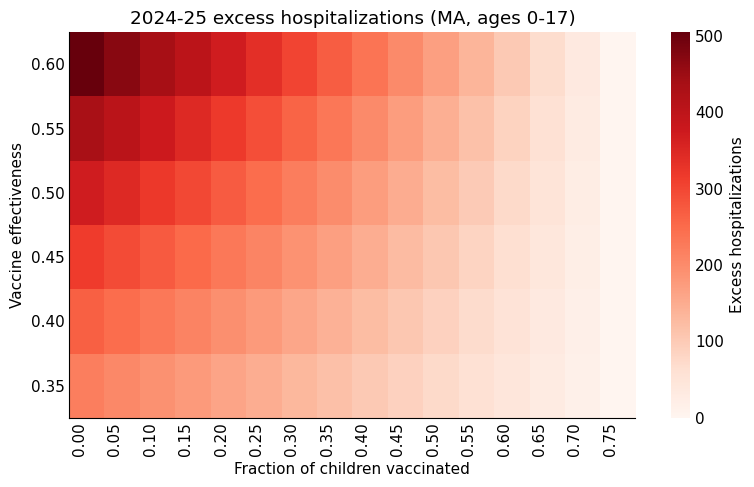

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
    'axes.facecolor': 'white',
})

pivot = (
    df_results.pivot_table(index='VE', columns='c1', values='excess_point', aggfunc='mean')
    .sort_index()
    .sort_index(axis=1)
)

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(pivot.values, aspect='auto', origin='lower', cmap='Reds')

ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels([f'{c:.2f}' for c in pivot.columns], rotation=90, ha='right')
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels([f'{v:.2f}' for v in pivot.index])
ax.set_xlabel('Fraction of children vaccinated')
ax.set_ylabel('Vaccine effectiveness')
ax.set_title('2024-25 excess hospitalizations (MA, ages 0-17)')
ax.tick_params(length=0)

cbar = fig.colorbar(im, ax=ax, label='Excess hospitalizations')
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0)

plt.tight_layout()
plt.show()


## Caveats
- Pediatric influenza hospitalizations for Massachusetts are only available in NHSN HRD starting in 2024-25.
- Coverage for 2024-25 uses the most recent published value (2023-24), but the baseline is fixed at 0.75 for the grid.
- This is a simple leaky-vaccine counterfactual with no herd effects or waning.
